#  オペレーティングシステム 演習 10
#  メモリ管理, ページング

名前と学生証番号を書け. Enter your name and student ID.

 * 名前 Name:
 * 学生証番号 Student ID:

# 1. 仮想記憶の状態を知るためのコマンド
## 1-1. free
* システムメモリ量

In [1]:
free

               total        used        free      shared  buff/cache   available
Mem:        59066724     4333896    49047156        1864     5685672    53950304
Swap:       16777212      385448    16391764


## 1-2. ps
* プロセス一覧が主目的だが, プロセスのメモリ使用量も表示している
  * VSZ : Virtual memory size 仮想メモリの使用量
  * RSS : Resident Set Size 物理メモリの使用量

In [2]:
ps auxww | head

USER         PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
root           1  0.0  0.0 166596 10596 ?        Ss   Nov07  22:03 /sbin/init
root           2  0.0  0.0      0     0 ?        S    Nov07   0:05 [kthreadd]
root           3  0.0  0.0      0     0 ?        I<   Nov07   0:00 [rcu_gp]
root           4  0.0  0.0      0     0 ?        I<   Nov07   0:00 [rcu_par_gp]
root           5  0.0  0.0      0     0 ?        I<   Nov07   0:00 [slub_flushwq]
root           6  0.0  0.0      0     0 ?        I<   Nov07   0:00 [netns]
root           8  0.0  0.0      0     0 ?        I<   Nov07   0:00 [kworker/0:0H-events_highpri]
root          10  0.0  0.0      0     0 ?        I<   Nov07   0:00 [mm_percpu_wq]
root          11  0.0  0.0      0     0 ?        S    Nov07   0:00 [rcu_tasks_rude_]


## 1-3. /usr/bin/time
* コマンドの実行にかかった時間を表示するというのが主目的だが実際には, プロセスの種々のリソース使用量(時間, CPU時間, メモリ, etc.)を表示する
* 特に
  * maxresident 物理メモリ利用量の最大値
  * major pagefaults
  * minor pagefaults
を表示してくれる

In [3]:
/usr/bin/time ls

os10_vm.sos.ipynb
0.00user 0.00system 0:00.00elapsed 60%CPU (0avgtext+0avgdata 2540maxresident)k
0inputs+0outputs (0major+109minor)pagefaults 0swaps


* manを見るとわかるがオプション次第で色々なものを表示してくれる
* getrsuageというシステムコールのコマンド版

## 1-4. top
* プロセス一覧が主目的だが, freeと同等の情報も表示している
* 端末内での実行が基本

```
top
```

## 1-5. vmstat
* システム全体の仮想記憶関係のアクティビティ(使用されている物理メモリ量, スワップアウト, スワップインの量など)を継続的に表示してくれる
* 以下は1秒毎に表示してくれる
* <font color="red">放っておくと終了しないので適当なところで ■ ボタンを押して止める</font>

In [4]:
vmstat 1

procs -----------memory---------- ---swap-- -----io---- -system-- ------cpu-----
 r  b   swpd   free   buff  cache   si   so    bi    bo   in   cs us sy id wa st
 0  0 385448 49041528 313576 5372380    2    2     2     3    0    0  0  0 99  0  0
 0  0 385448 49041528 313576 5372380    0    0     0     0 2304 3761  0  0 99  0  0
 0  0 385448 49041528 313576 5372380    0    0     0     0 2235 3598  0  0 99  0  0
 0  0 385448 49041528 313576 5372380    0    0     0     0 2290 3787  0  0 99  0  0
 1  0 385448 49041528 313576 5372380    0    0     0     0 2165 3645  0  0 100  0  0
 0  0 385448 49041528 313576 5372380    0    0     0     0 2167 3595  0  0 99  0  0
 2  0 385448 49041528 313576 5372380    0    0     0    12 2226 3680  0  0 100  0  0
 0  0 385448 49041528 313576 5372380    0    0     0     0 2458 3854  1  0 99  0  0
 0  0 385448 49041528 313576 5372380    0    0     0     0 2208 3668  1  0 99  0  0
 0  0 385448 49040520 313576 5372380    0    0     0     0 2285 3559  0  0 99  0

# 2. 要求時ページング
* OSから割り当てられたメモリ領域は, 割り当てられた時点では物理メモリは割り当てられていない
* あるページに初めてアクセスしたときに<font color="blue">ページフォルト</font>がおき, そのときにOSが物理ページを割り当てる
* したがってメモリ割り当てそのものは大きな領域でもすぐに終わるし, 物理メモリ量を超える領域も割り当てることが出来る
* その後実際にアクセスした領域に対して時間がかかる

* 以下のプログラムは
  * 大きな配列(Nバイト)を割り当てる
  * それをある間隔(Sバイト)で何度もアクセスする. 配列の最後まで行ったら先頭に戻る. 正確にはi回目は(S * i) % Nバイト目をアクセスする
  * それをしながら時折, 時間とページフォルト数を計測する
  * ある回数ごとに一回, iの値を表示する

In [5]:
%%writefile page_fault_rec.c
//% file: page_fault_rec_1.c
//% cmd: gcc -O3 -Wall -Wextra -o page_fault_rec_1 page_fault_rec_1.c

#include <assert.h>
#include <err.h>
#include <fcntl.h>
#include <limits.h>
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/mman.h>
#include <sys/resource.h>
#include <sys/stat.h>
#include <sys/time.h>
#include <sys/types.h>
#include <unistd.h>

const long page_sz = 4096;

/* 実行時間とページフォルト回数の記録 */
typedef struct {
  struct timeval tv;
  struct rusage ru;
} timeval_rusage;

/* 実行時間とページフォルト回数をtrに記録する */
void record_timeval_rusage(timeval_rusage * tr) {
  if (gettimeofday(&tr->tv, 0) == -1) { err(1, "gettimeofday"); }
  if (getrusage(RUSAGE_SELF, &tr->ru) == -1) { err(1, "getrusage"); }
}

/* 実行時間とページフォルト回数の記録tr[0]〜tr[n_records-1]
   をファイルtime_usage_datに保存する */
void save_timeval_rusage(const char * time_usage_dat,
                         timeval_rusage * tr,
                         long n_records,
                         long record_interval) {
  FILE * wp = fopen(time_usage_dat, "w");
  if (!wp) { err(1, "fopen"); }
  for (long i = 0; i < n_records; i++) {
    fprintf(wp, "%ld\t%f\t%ld\t%ld\n", 
            i * record_interval * 4096,
            tr[i].tv.tv_sec + tr[i].tv.tv_usec * 1.0e-6,
            tr[i].ru.ru_minflt,
            tr[i].ru.ru_majflt);
  }
  fclose(wp);
}




/* 
   usage:
     ./page_fault_rec N S A RI
   (1) N MBの領域を割り当てる (デフォルト64 MB)
   (2) S > 0ならば二つのアクセス間の距離 (デフォルト 4096) -1ならばランダム
   (3) A 回 (2)に従ってページをアクセス (デフォルト -1). -1の場合, A = N * 256 * 3
       (N MB のページ数 x 3)
   (4) RIアクセスごとに時刻と, ページフォルト数を記録する 
       (デフォルト 500アクセス)
 */

int main(int argc, char ** argv) {
  int i = 1;
  /* 配列のサイズ(MB) */
  long n_mb            = (argc > i ? atol(argv[i]) : 64); i++;
  /* STRIDE>0 -> バイト飛ばしでアクセス */
  long stride          = (argc > i ? atol(argv[i]) : page_sz); i++;
  /* アクセス回数(デフォルトは配列のページ数 x 3回) */
  long n_accesses      = (argc > i ? atol(argv[i]) : -1); i++;
  /* 記録間隔 */
  long record_interval = (argc > i ? atol(argv[i]) : 500); i++;
  long sz = n_mb * 1024L * 1024L; /* size in bytes */
  long n_pages = (sz + page_sz - 1) / page_sz;
  if (n_accesses == -1) n_accesses = n_pages * 3;
  long n_records = (n_accesses + record_interval - 1) / record_interval;
  char * a = (char *)sbrk(sz);
  if (!a) { err(1, "sbrk"); }
  timeval_rusage * tr = malloc(sizeof(timeval_rusage) * n_records);
  if (!tr) { err(1, "malloc"); }
  long idx = 0;                 /* 次にアクセスする要素 */
  /* report_interval 回アクセスごとに . を打つ */
  const long n_dots = 100;
  long report_interval = (n_accesses + n_dots - 1) / n_dots;

  fprintf(stderr, "touching %ld MB %ld times\n", n_mb, n_accesses);
  long s = 0;
  for (long i = 0; i < n_accesses; i++) {
    if (i % report_interval == 0) {
      /* 進捗表示 */
      putchar('.'); fflush(stdout);
    }
    if (i % record_interval == 0) {
      /* 時間を記録 */
      long k = i / record_interval; /* 記録回数 */
      assert(k < n_records);
      record_timeval_rusage(&tr[k]);
    }
    idx = idx % sz;
    s += (a[idx]++);
    idx += stride;
  }
  assert((n_accesses - 1) / record_interval + 1 == n_records);
  /* save time and page faults */
  save_timeval_rusage("time_rusage.dat", tr, n_records, record_interval);
  printf("\ndone s = %ld\n", s);
  return 0;
}


Writing page_fault_rec.c


In [6]:
gcc -Wall -O3 -o page_fault_rec page_fault_rec.c

* 以下のコマンドは, 192MBの配列を4096バイトごとに, (256 * 192 * 3)回アクセスする
* 回数は, 192MBの配列の全ページを3回アクセスする回数(256回=1MB)

In [7]:
%system
! N=192; ./page_fault_rec ${N} 4096 $((256 * ${N} * 3)) 500

touching 192 MB 147456 times
....................................................................................................
done s = 147456


* <font color="purple">以下のNを変えて(大きくして)みよ</font>
* よく見ると1回目と2回目以降で速度が違うことを目視してみよ

In [25]:
%system
! N=19200; ./page_fault_rec ${N} 4096 $((256 * ${N} * 3)) 500

touching 49200 MB 37785600 times
........................^C


* 以下はこの結果を可視化する

In [21]:
#!/usr/bin/python3
import sys
import re
import matplotlib.collections as mc
import matplotlib.pyplot as plt
import numpy as np

def read_dat(dat):
    # 2	0.000598	0	1025
    pat = re.compile("(?P<accessed>\d+)	(?P<t>\d+\.\d+)	(?P<minflt>\d+)	(?P<majflt>\d+)")
    log = []
    with open(dat) as fp:
        for line in fp:
            m = pat.match(line)
            if not m:
                sys.stderr.write("warning: ignore line [%s]\n" % line.rstrip())
                continue
            D = m.groupdict()
            D = {k : float(D[k]) for k in D}
            log.append(D)
    return log
    
def progress_plt(dat, xlabel, ylabel):
    log = read_dat(dat)
    fig, ax = plt.subplots()
    X = np.array([d[xlabel] for d in log])
    Y = np.array([d[ylabel] for d in log])
    ax.plot(X, Y - Y[0])
    ax.autoscale()
    plt.title(dat)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def main():
    time_rusage_dat = sys.argv[1]
    progress_plt(time_rusage_dat, "accessed", "t")
    progress_plt(time_rusage_dat, "accessed", "minflt")
    progress_plt(time_rusage_dat, "accessed", "majflt")
    
if sys.argv[0].endswith("page_fault_vis.py"):
    main()


* アクセス量 vs 時間の表示

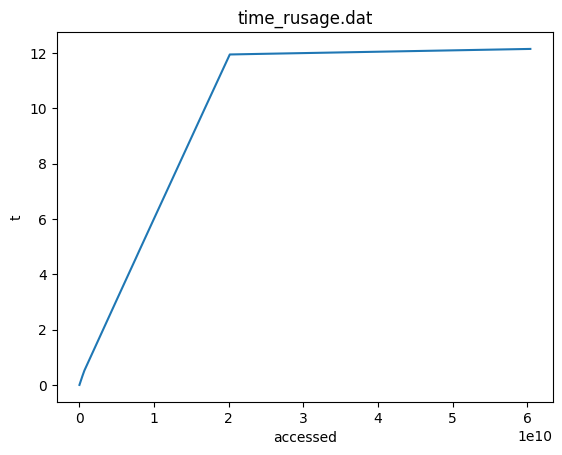

In [22]:
progress_plt("time_rusage.dat", "accessed", "t")

* getrusageというシステムコールでページフォルトの回数を取得できる

* アクセス量 vs マイナーページフォルトの表示
* マイナーページフォルトはページフォルトの中で, IOが発生しない(初めてのアクセスでおきる)もの
* どのようなグラフが現れるか予想してから実行せよ
* Nを変えて, 回数がどう変わるか, それが理にかなっているか確認せよ

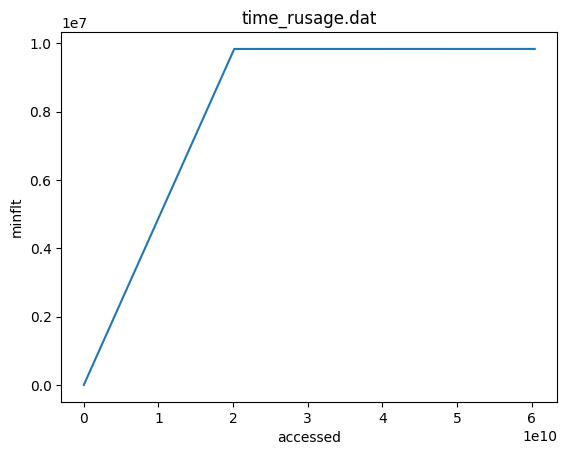

In [23]:
progress_plt("time_rusage.dat", "accessed", "minflt")

* アクセス量 vs メジャーページフォルトの表示
* メジャーページフォルトはページフォルトの中で, IOが発生する(一度アクセスした後2次記憶に追い出されたページをまたアクセスしたときにおきる)もの
* この実行でメジャーページフォルトはおきるか? どのようなグラフが現れるか考えてから実行せよ

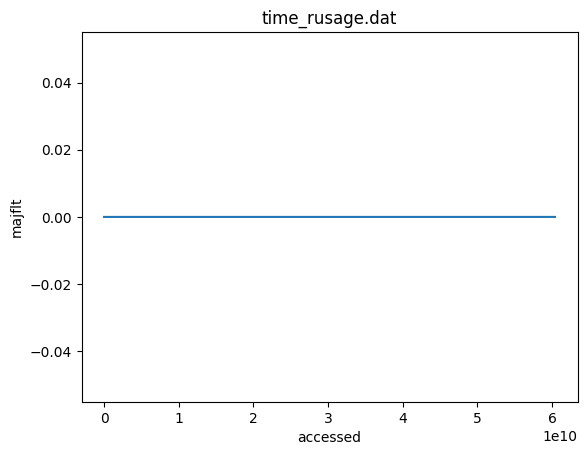

In [24]:
progress_plt("time_rusage.dat", "accessed", "majflt")

# 3. cgroupによるメモリ使用量の制限
* メジャーページフォルトは物理メモリが逼迫したときに起こるので, 通常はおこらない
* 実際それが起きるような状況は, 「メモリが足りない」という状況で, コンピュータの動作事態に悪影響がある
* Jupyterの実験環境は128GBのメモリを搭載しているが, 無理矢理128GBのメモリを使って実行したら, 悲惨なことが起きるので決してやらないこと
* ここでは Linux のcgroupという仕組みを使って特定プロセスに対してメモリ量を制限して実行する
* 細かい仕組みは省略するが, 以下(cg_mem_limit)は, cgroupを用いて256MBにメモリ使用量を制限した上で実行するコマンド

In [27]:
%system
! N=192; cg_mem_limit ./page_fault_rec ${N} 4096 $((256 * ${N} * 3)) 500

touching 192 MB 147456 times
....................................................................................................
done s = 147456


* 以下でNを変えて, 256MBよりも少し小さな, または少し大きな配列をアクセスするようにしてみよ
* 256MBよりも大きな配列をアクセスしつつ, ストライド(以下の4096)を変えて見よ. 例えば8192にすると, 2ページに一回アクセスすることになる. 結果を予想しつつ実験せよ

In [34]:
%system
! N=1902; cg_mem_limit ./page_fault_rec ${N} 4096 $((256 * ${N} * 3)) 500

touching 1902 MB 1460736 times
....................................................................................................
done s = 1460736


* 時間

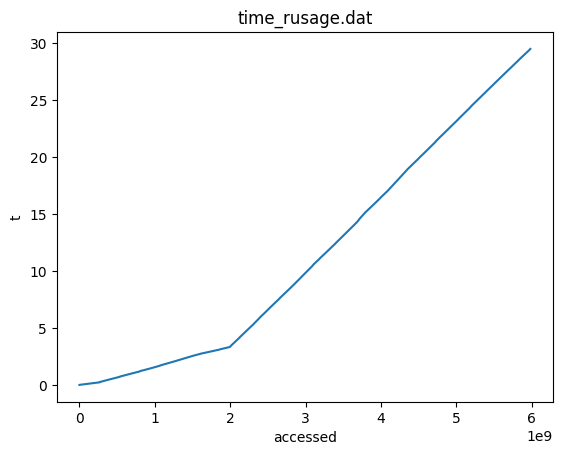

In [35]:
progress_plt("time_rusage.dat", "accessed", "t")

* マイナーフォルト

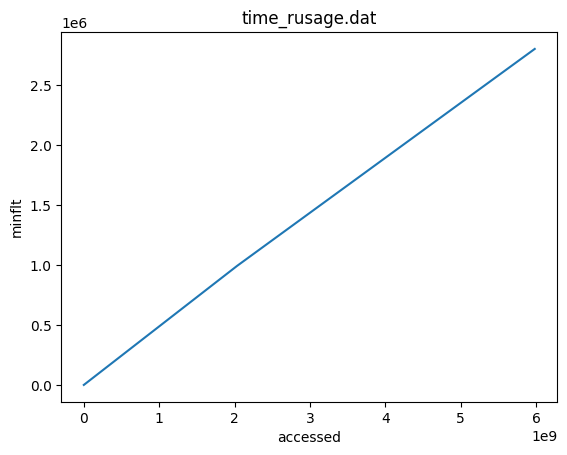

In [37]:
progress_plt("time_rusage.dat", "accessed", "minflt")

* メジャーフォルト

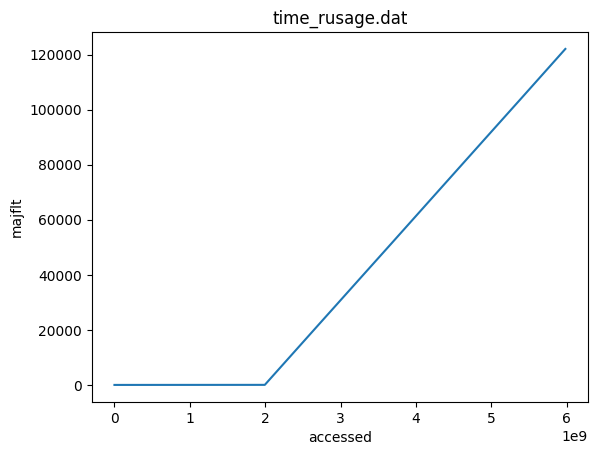

In [38]:
progress_plt("time_rusage.dat", "accessed", "majflt")

# 4. ページ置換の可視化
* Linuxでは mincore というシステムコールを用いて, どのページに物理メモリが割り当てられているかを取得できる
* 以下はそれを用いて, どのページに物理メモリが割り当てられているかを記録する

In [39]:
%%writefile mincore_rec.c
//% file: page_fault_rec_2.c
//% cmd: gcc -O3 -Wall -Wextra -o page_fault_rec_2 page_fault_rec_2.c

#include <assert.h>
#include <err.h>
#include <fcntl.h>
#include <limits.h>
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/mman.h>
#include <sys/resource.h>
#include <sys/stat.h>
#include <sys/time.h>
#include <sys/types.h>
#include <unistd.h>

const long page_sz = 4096;

/* 実行時間とページフォルト回数の記録 */
typedef struct {
  struct timeval tv;
  struct rusage ru;
} timeval_rusage;

/* 実行時間とページフォルト回数をtrに記録する */
void record_timeval_rusage(timeval_rusage * tr) {
  if (gettimeofday(&tr->tv, 0) == -1) { err(1, "gettimeofday"); }
  if (getrusage(RUSAGE_SELF, &tr->ru) == -1) { err(1, "getrusage"); }
}

/* 実行時間とページフォルト回数の記録tr[0]〜tr[n_records-1]
   をファイルtime_usage_datに保存する */
void save_timeval_rusage(const char * time_usage_dat,
                         timeval_rusage * tr,
                         long n_records,
                         long record_interval) {
  FILE * wp = fopen(time_usage_dat, "w");
  if (!wp) { err(1, "fopen"); }
  for (long i = 0; i < n_records; i++) {
    fprintf(wp, "%ld\t%f\t%ld\t%ld\n", 
            i * record_interval * 4096,
            tr[i].tv.tv_sec + tr[i].tv.tv_usec * 1.0e-6,
            tr[i].ru.ru_minflt,
            tr[i].ru.ru_majflt);
  }
  fclose(wp);
}

/* addr[0:length]中のどのページがメモリ上にあるか
   + 最後にアクセスしたアドレス(last_accessed)を記録する */
void record_incore(FILE * wp, 
		   void * addr, size_t length, unsigned char * R,
		   long * mru, long n_mru) {
  size_t n_pages = (length + page_sz - 1) / page_sz;
  struct timeval tp[1];
  if (gettimeofday(tp, NULL) == -1) { perror("gettimeofday"); exit(1); }
  double t = tp->tv_sec + tp->tv_usec * 1.0e-6;
  /* get current time */
  fprintf(wp, "%f\n", t);
  if (mincore(addr, length, R) == -1) {
    err(1, "mincore");
  }
  fprintf(wp, "%lu\n", n_pages);
  size_t c = fwrite(R, n_pages, 1, wp);
  if (c != 1) {
    err(1, "fwrite");
  }

  fprintf(wp, "%ld\n", n_mru);
  c = fwrite(mru, sizeof(long), n_mru, wp);
  if (c != (size_t)n_mru) {
    err(1, "fwrite");
  }
}



/* 
   usage:
     ./page_fault_rec N S A RI
   (1) N MBの領域を割り当てる (デフォルト64 MB)
   (2) S > 0ならば二つのアクセス間の距離 (デフォルト 4096) -1ならばランダム
   (3) A 回 (2)に従ってページをアクセス (デフォルト -1). -1の場合, A = N * 256 * 3
       (N MB のページ数 x 3)
   (4) RIアクセスごとに時刻と, ページフォルト数を記録する 
       (デフォルト 500アクセス)
   (5) RIアクセスごとに, メモリ上にあるページを記録する
 */

int main(int argc, char ** argv) {
  int i = 1;
  /* 配列のサイズ(MB) */
  long n_mb            = (argc > i ? atol(argv[i]) : 64); i++;
  /* STRIDE>0 -> バイト飛ばしでアクセス */
  long stride          = (argc > i ? atol(argv[i]) : page_sz); i++;
  /* アクセス回数(デフォルトは配列のページ数 x 3回) */
  long n_accesses      = (argc > i ? atol(argv[i]) : -1); i++;
  /* 記録間隔 */
  long record_interval = (argc > i ? atol(argv[i]) : 500); i++;
  long sz = n_mb * 1024L * 1024L; /* size in bytes */
  long n_pages = (sz + page_sz - 1) / page_sz;
  if (n_accesses == -1) n_accesses = n_pages * 3;
  long n_records = (n_accesses + record_interval - 1) / record_interval;
  char * a = (char *)sbrk(sz);
  if (!a) { err(1, "sbrk"); }
  timeval_rusage * tr = malloc(sizeof(timeval_rusage) * n_records);
  if (!tr) { err(1, "malloc"); }
  unsigned char * R = calloc(sizeof(unsigned char), n_pages);
  if (!R) { err(1, "calloc"); }
  FILE * wp = fopen("mincore.dat", "wb");
  if (!wp) { err(1, "fopen"); }
  long * mru = calloc(sizeof(long), record_interval);
  if (!mru) { err(1, "calloc"); }
  long idx = 0;                 /* 次にアクセスする要素 */
  /* report_interval 回アクセスごとに . を打つ */
  const long n_dots = 100;
  long report_interval = (n_accesses + n_dots - 1) / n_dots;

  fprintf(stderr, "touching %ld MB %ld times\n", n_mb, n_accesses);
  long s = 0;
  for (long i = 0; i < n_accesses; i++) {
    if (i % report_interval == 0) {
      /* 進捗表示 */
      putchar('.'); fflush(stdout);
    }
    if (i % record_interval == 0) {
      /* 時間を記録 */
      long k = i / record_interval; /* 記録回数 */
      assert(k < n_records);
      record_timeval_rusage(&tr[k]);
      /* メモリ上のページを記録 */
      record_incore(wp, a, sz, R, mru, (i ? record_interval : 0));
    }
    idx = idx % sz;
    s += (a[idx]++);
    mru[i % record_interval] = idx;
    idx += stride;
  }
  assert((n_accesses - 1) / record_interval + 1 == n_records);
  fclose(wp);
  /* save time and page faults */
  save_timeval_rusage("time_rusage.dat", tr, n_records, record_interval);
  printf("\ndone s = %ld\n", s);
  return 0;
}


Writing mincore_rec.c


In [40]:
gcc -Wall -O3 -o mincore_rec mincore_rec.c

## 4-1. 実行
* Nやストライドを変えて実行, 可視化してみよ
* cg_mem_limit はプロセスの使用可能物理メモリ量を256 MBに制限するので以下のNが256に近づくかそれを超える当たりで挙動が大幅に変化する
* それを確認せよ

In [41]:
%system
! N=192; cg_mem_limit ./mincore_rec ${N} 4096 $((256 * ${N} * 3)) 500

touching 192 MB 147456 times
....................................................................................................
done s = 147456


* その可視化プログラムは以下

In [42]:
#!/usr/bin/python3
import math
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
from IPython import display 

def put_circle(img, cy, cx, r):
    h,w = img.shape
    for dx in range(-r, r + 1):
        for dy in range(-r, r + 1):
            if 0 <= cx + dx < w and 0 <= cy + dy < h and dx * dx + dy * dy <= r * r:
                img[cy+dy,cx+dx] = 1.0

def make_img(bm, mru):
    n_bytes, = bm.shape
    width = 256
    height = (n_bytes + width - 1) // width
    img = np.zeros((width * height), dtype=float)
    img[:n_bytes] = 0.4 * bm
    for idx in mru:
        p = int(idx) // 4096
        img[p] = 1.0
    img = img.reshape((height, width))
    for idx in mru:
        p = int(idx) // 4096
        cy = p // width
        cx = p  % width
        assert(img[cy,cx] == 1.0)
        put_circle(img, cy, cx, 1)
    X = np.array(range(width))
    Y = np.array(range(height))
    X,Y = np.meshgrid(X,Y)
    assert(X.shape == (height, width))
    return X, Y, img
        
def shrink(z):
    # z : 2次元配列 を縦横1ずつ縮めて, かつ無理やり1次元の配列に直す
    # (以前は set_array に必要だったが不要になた)
    m,n = z.shape
    return z[:m-1,:n-1].reshape((m - 1) * (n - 1))
    
def generate_mincore_frames(writer, fig, mincore_dat, animation_speed):
    # mincore_dat : filename
    # animation_speed :
    # change this value to change animation speed
    # 1.0 means animation runs as fast as the real execution.
    # smaller value means slower animation
    t0 = time.time()
    t = 0
    ax = fig.add_subplot(111)
    with open(mincore_dat, "rb") as fp:
        im = None
        txt = None
        frames = 0
        while 1:
            print(".", end="", flush=True)
            line = fp.readline()
            if line == b"":
                break
            if im is None:
                record_time0 = float(line)
                record_time = 0
            else:
                record_time = float(line) - record_time0
            n_pages = int(fp.readline())
            bm = np.fromfile(fp, dtype=np.uint8, count=n_pages)
            assert(bm.shape == (n_pages,)), (bm.shape, n_pages)
            line = fp.readline()
            n_mrus = int(line)
            mru = np.fromfile(fp, dtype=np.uint64, count=n_mrus)
            assert(mru.shape == (n_mrus,)), (mru.shape, n_mrus)
            t = (time.time() - t0) * animation_speed
            if im is None or t < record_time:
                X, Y, img = make_img(bm, mru)
                if im is None:
                    # show the first frame
                    height, _ = img.shape
                    cmap = plt.cm.get_cmap('bwr')
                    im = ax.pcolor(X, Y, img, cmap=cmap, vmin=0.0, vmax=1.0)
                    txt = ax.text(160, -height/7.5, "",
                                  horizontalalignment="right")
                    print("*", end="", flush=True)
                    writer.grab_frame()
                    # yield im,
                im.set_array(img)
                while t < record_time:
                    txt.set_text("real time : %.3f\nrecorded time: %.3f"
                                 % (t, record_time))
                    print("*", end="", flush=True)
                    writer.grab_frame()
                    # yield im,
                    t = (time.time() - t0) * animation_speed
            frames += 1
        # last image
        if im:
            X, Y, img = make_img(bm, mru)
            im.set_array(img)
            txt.set_text("real time : %.3f\nrecorded time: %.3f"
                         % (t, record_time))
            print("*", end="", flush=True)
            writer.grab_frame()
            # yield im,
        print("done")

def animate_mincore(mincore_dat, out_mp4, animation_speed):
    writer = anm.FFMpegWriter(fps=15) # fps=15, metadata={"artist": "Me"}, bitrate=1800)
    fig = plt.figure()
    with writer.saving(fig, out_mp4, dpi=100):
        generate_mincore_frames(writer, fig, mincore_dat, animation_speed)
        
def main():
    if len(sys.argv) <= 2:
        sys.stderr.write("usage: %s mincore_dat out_mp4\n" % sys.argv[0])
        sys.stderr.write(" file is a log file written by record mincore\n")
        sys.exit(1)
    micore_dat = sys.argv[1]
    out_mp4 = sys.argv[2]
    return animate_mincore(micore_dat, out_mp4, 0.05)

if sys.argv[0].endswith("mincore_vis.py"):
    main()

* 以下を実行すると動画ファイル(mincore.mp4)が生成, 表示される
  * 動画と終了状態の静止画が両方表示されてしまうが気にしない
* 動画の再生ボタンで再生する
* 以下でNを, 256より十分小さな値(192)から256よりわずかに小さい値, 256を少し超える値などに変えて可視化してみよ
* animate_mincoreの3つめのパラメータ(0.05)は保存される動画の再生速度(フレーム数)を調整するもので, 大きくすると早く(短時間で)再生され, 小さくすると遅くなる

In [47]:
%system
! N=192; cg_mem_limit ./mincore_rec ${N} 4096 $((256 * ${N} * 3)) 500

touching 192 MB 147456 times
....................................................................................................
done s = 147456


.

/tmp/ipykernel_3027185/917081941.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr')


*..............*...*...*...*..*...*..*..*..*...*..*..*..*...*..*..*..*...*..*..*..*...*..*..*...*..*..*..*...*..*..*...*..*..*..*...*..*..............................*...........................................*...........................................*...........................................*......................................*done


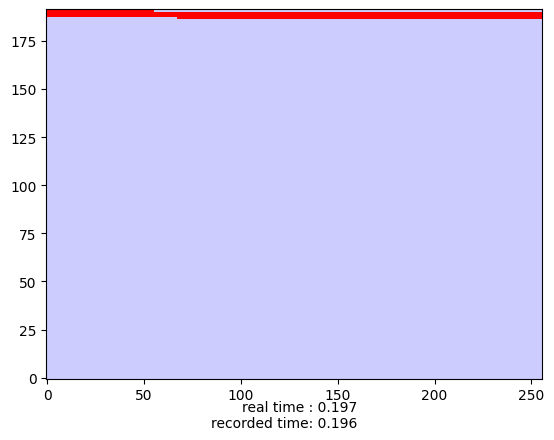

In [48]:
from IPython.display import Video
animate_mincore("mincore.dat", "mincore.mp4", 0.05)
Video("mincore.mp4")

## 4-2. ランダムアクセス
* 以下は, 2番めの引数を-1にすると配列をランダムにアクセスするようにしたもの

In [49]:
%%writefile mincore_random_rec.c
//% file: page_fault_rec_3.c
//% cmd: gcc -O3 -Wall -Wextra -o page_fault_rec_3 page_fault_rec_3.c

#include <assert.h>
#include <err.h>
#include <fcntl.h>
#include <limits.h>
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/mman.h>
#include <sys/resource.h>
#include <sys/stat.h>
#include <sys/time.h>
#include <sys/types.h>
#include <unistd.h>

const long page_sz = 4096;

/* 実行時間とページフォルト回数の記録 */
typedef struct {
  struct timeval tv;
  struct rusage ru;
} timeval_rusage;

/* 実行時間とページフォルト回数をtrに記録する */
void record_timeval_rusage(timeval_rusage * tr) {
  if (gettimeofday(&tr->tv, 0) == -1) { err(1, "gettimeofday"); }
  if (getrusage(RUSAGE_SELF, &tr->ru) == -1) { err(1, "getrusage"); }
}

/* 実行時間とページフォルト回数の記録tr[0]〜tr[n_records-1]
   をファイルtime_usage_datに保存する */
void save_timeval_rusage(const char * time_usage_dat,
                         timeval_rusage * tr,
                         long n_records,
                         long record_interval) {
  FILE * wp = fopen(time_usage_dat, "w");
  if (!wp) { err(1, "fopen"); }
  for (long i = 0; i < n_records; i++) {
    fprintf(wp, "%ld\t%f\t%ld\t%ld\n", 
            i * record_interval * 4096,
            tr[i].tv.tv_sec + tr[i].tv.tv_usec * 1.0e-6,
            tr[i].ru.ru_minflt,
            tr[i].ru.ru_majflt);
  }
  fclose(wp);
}

/* addr[0:length]中のどのページがメモリ上にあるか
   + 最後にアクセスしたアドレス(last_accessed)を記録する */
void record_incore(FILE * wp, 
		   void * addr, size_t length, unsigned char * R,
		   long * mru, long n_mru) {
  size_t n_pages = (length + page_sz - 1) / page_sz;
  struct timeval tp[1];
  if (gettimeofday(tp, NULL) == -1) { perror("gettimeofday"); exit(1); }
  double t = tp->tv_sec + tp->tv_usec * 1.0e-6;
  /* get current time */
  fprintf(wp, "%f\n", t);
  if (mincore(addr, length, R) == -1) {
    err(1, "mincore");
  }
  fprintf(wp, "%lu\n", n_pages);
  size_t c = fwrite(R, n_pages, 1, wp);
  if (c != 1) {
    err(1, "fwrite");
  }

  fprintf(wp, "%ld\n", n_mru);
  c = fwrite(mru, sizeof(long), n_mru, wp);
  if (c != (size_t)n_mru) {
    err(1, "fwrite");
  }
}



/* 
   usage:
     ./page_fault_rec N S A RI
   (1) N MBの領域を割り当てる (デフォルト64 MB)
   (2) S > 0ならば二つのアクセス間の距離 (デフォルト 4096) -1ならばランダム
   (3) A 回 (2)に従ってページをアクセス (デフォルト -1). -1の場合, A = N * 256 * 3
       (N MB のページ数 x 3)
   (4) RIアクセスごとに時刻と, ページフォルト数を記録する 
       (デフォルト 500アクセス)
   (5) RIアクセスごとに, メモリ上にあるページを記録する
 */

int main(int argc, char ** argv) {
  int i = 1;
  /* 配列のサイズ(MB) */
  long n_mb            = (argc > i ? atol(argv[i]) : 64); i++;
  /* アクセス回数(デフォルトは配列のページ数 x 3回) */
  long n_accesses      = (argc > i ? atol(argv[i]) : -1); i++;
  /* 記録間隔 */
  long record_interval = (argc > i ? atol(argv[i]) : 500); i++;
  /* 乱数の種 */
  long seed            = (argc > i ? atol(argv[i]) : 1234567890123L); i++;
  long sz = n_mb * 1024L * 1024L; /* size in bytes */
  long n_pages = (sz + page_sz - 1) / page_sz;
  if (n_accesses == -1) n_accesses = n_pages * 3;
  long n_records = (n_accesses + record_interval - 1) / record_interval;
  char * a = (char *)sbrk(sz);
  if (!a) { err(1, "sbrk"); }
  timeval_rusage * tr = malloc(sizeof(timeval_rusage) * n_records);
  if (!tr) { err(1, "malloc"); }
  unsigned char * R = calloc(sizeof(unsigned char), n_pages);
  if (!R) { err(1, "calloc"); }
  FILE * wp = fopen("mincore.dat", "wb");
  if (!wp) { err(1, "fopen"); }
  long * mru = calloc(sizeof(long), record_interval);
  if (!mru) { err(1, "calloc"); }
  unsigned short rg[3] = { seed >> 32, seed >> 16, seed };
  long idx = 0;                 /* 次にアクセスする要素 */
  /* report_interval 回アクセスごとに . を打つ */
  const long n_dots = 100;
  long report_interval = (n_accesses + n_dots - 1) / n_dots;

  fprintf(stderr, "touching %ld MB %ld times\n", n_mb, n_accesses);
  long s = 0;
  for (long i = 0; i < n_accesses; i++) {
    if (i % report_interval == 0) {
      /* 進捗表示 */
      putchar('.'); fflush(stdout);
    }
    if (i % record_interval == 0) {
      /* 時間を記録 */
      long k = i / record_interval; /* 記録回数 */
      assert(k < n_records);
      record_timeval_rusage(&tr[k]);
      /* メモリ上のページを記録 */
      record_incore(wp, a, sz, R, mru, (i ? record_interval : 0));
    }
    idx = idx % sz;
    s += (a[idx]++);
    mru[i % record_interval] = idx;
    idx = nrand48(rg);
  }
  assert((n_accesses - 1) / record_interval + 1 == n_records);
  fclose(wp);
  /* save time and page faults */
  save_timeval_rusage("time_rusage.dat", tr, n_records, record_interval);
  printf("\ndone s = %ld\n", s);
  return 0;
}


Writing mincore_random_rec.c


In [50]:
gcc -Wall -O3 -o mincore_random_rec mincore_random_rec.c

## 4-3. 実行
* Nやストライドを変えて実行

In [56]:
%system
! N=300; cg_mem_limit ./mincore_random_rec ${N} $((256 * ${N} * 3)) 500

touching 300 MB 230400 times
....................................................................................................
done s = 88


* 可視化

* 時間

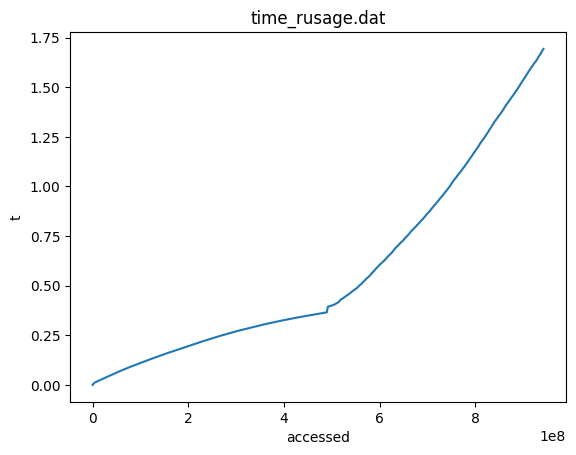

In [57]:
progress_plt("time_rusage.dat", "accessed", "t")

* マイナーフォルト

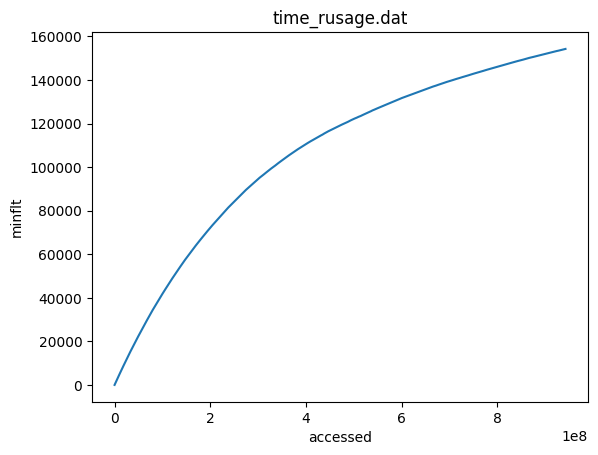

In [59]:
progress_plt("time_rusage.dat", "accessed", "minflt")

* メジャーフォルト

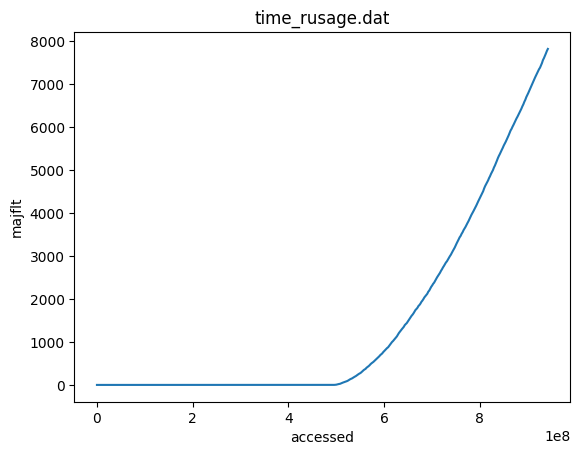

In [60]:
progress_plt("time_rusage.dat", "accessed", "majflt")

* アニメーション

.

/tmp/ipykernel_3027185/917081941.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr')


*................................................................................................................................................................................................................................................*........................*..................*................*..............*...............*..............*..............*............*............*...........*..........*..........*...........*........*........*........*........*.......*.*done


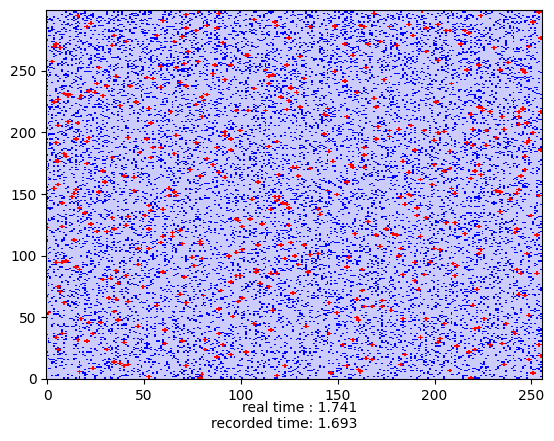

In [61]:
from IPython.display import Video
animate_mincore("mincore.dat", "mincore.mp4", 0.5)
Video("mincore.mp4")

# 5. madviseによるページング制御
## 5-1. 実行 (Nやストライドを変えて実行, 可視化してみよ)
* cg_mem_limitは, 物理メモリ量を256MBに制限してプログラムを実行する
* ./mincore_rec は N MB の配列を何度もスキャンする
* LRU(を近似した)置換のせいで, 物理メモリ使用量が 256 MBを少しでも超えると, ページフォルト率がほぼ1になってしまう

In [62]:
%system
! N=260; cg_mem_limit ./mincore_rec ${N} 4096 $((256 * ${N} * 5)) 500

touching 260 MB 332800 times
....................................................................................................
done s = 665600


## 5-2. madvise
* madviseはOSにアクセスパターンを教えてページングアルゴリズムにヒントを与えるものだが, 中でもPAGE_OUTというアドバイスは, 指定した領域を即座にページアウトする, 直接的な指示になる
* 以下はこれをつかって, 上記のプログラムのページングの挙動を変えて大幅に高速化する例である
* 256MBがほぼ埋まったところで, 配列の後半, 256MBに収まらない部分を, madvise を使って PAGE_OUT する
* 結果的に, 配列の前半約 256MB が常に物理メモリに載っていることになり, ページフォルト率を (N-256)/N 程度に抑えることが出来る

In [63]:
%%writefile madvise_rec.c
//% file: page_fault_rec_4.c
//% cmd: gcc -O3 -Wall -Wextra -o page_fault_rec_4 page_fault_rec_4.c

#include <assert.h>
#include <err.h>
#include <fcntl.h>
#include <limits.h>
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/mman.h>
#include <sys/resource.h>
#include <sys/stat.h>
#include <sys/time.h>
#include <sys/types.h>
#include <unistd.h>

const long page_sz = 4096;

/* 実行時間とページフォルト回数の記録 */
typedef struct {
  struct timeval tv;
  struct rusage ru;
} timeval_rusage;

/* 実行時間とページフォルト回数をtrに記録する */
void record_timeval_rusage(timeval_rusage * tr) {
  if (gettimeofday(&tr->tv, 0) == -1) { err(1, "gettimeofday"); }
  if (getrusage(RUSAGE_SELF, &tr->ru) == -1) { err(1, "getrusage"); }
}

/* 実行時間とページフォルト回数の記録tr[0]〜tr[n_records-1]
   をファイルtime_usage_datに保存する */
void save_timeval_rusage(const char * time_usage_dat,
                         timeval_rusage * tr,
                         long n_records,
                         long record_interval) {
  FILE * wp = fopen(time_usage_dat, "w");
  if (!wp) { err(1, "fopen"); }
  for (long i = 0; i < n_records; i++) {
    fprintf(wp, "%ld\t%f\t%ld\t%ld\n", 
            i * record_interval * 4096,
            tr[i].tv.tv_sec + tr[i].tv.tv_usec * 1.0e-6,
            tr[i].ru.ru_minflt,
            tr[i].ru.ru_majflt);
  }
  fclose(wp);
}

/* addr[0:length]中のどのページがメモリ上にあるか
   + 最後にアクセスしたアドレス(last_accessed)を記録する */
void record_incore(FILE * wp, 
		   void * addr, size_t length, unsigned char * R,
		   long * mru, long n_mru) {
  size_t n_pages = (length + page_sz - 1) / page_sz;
  struct timeval tp[1];
  if (gettimeofday(tp, NULL) == -1) { perror("gettimeofday"); exit(1); }
  double t = tp->tv_sec + tp->tv_usec * 1.0e-6;
  /* get current time */
  fprintf(wp, "%f\n", t);
  if (mincore(addr, length, R) == -1) {
    err(1, "mincore");
  }
  fprintf(wp, "%lu\n", n_pages);
  size_t c = fwrite(R, n_pages, 1, wp);
  if (c != 1) {
    err(1, "fwrite");
  }

  fprintf(wp, "%ld\n", n_mru);
  c = fwrite(mru, sizeof(long), n_mru, wp);
  if (c != (size_t)n_mru) {
    err(1, "fwrite");
  }
}

typedef struct {
  long ts;                      /* ts >= 0 <--> on memory */
} timestamp_t;

/* 配列の後半(target_resident_pages ページ目以降)を evict する */
long evict_pages(char * a, long sz, 
                 timestamp_t * timestamps,
                 long target_resident_pages,
                 long n_resident_pages) {
  (void)n_resident_pages;
  long n_pages = (sz + page_sz - 1) / page_sz;
  for (long i = n_pages - target_resident_pages; i < n_pages; i++) {
    timestamps[i].ts = -1;
  }
  long offset = target_resident_pages * page_sz;
  long len = (n_pages - target_resident_pages) * page_sz;
  if (madvise(a + offset, len, MADV_PAGEOUT) == -1) {
    err(1, "madvise");
  }
  return target_resident_pages;
}


/* 
   usage:
     ./page_fault_rec N S A RI
   (1) N MBの領域を割り当てる (デフォルト64 MB)
   (2) S > 0ならば二つのアクセス間の距離 (デフォルト 4096) -1ならばランダム
   (3) A 回 (2)に従ってページをアクセス (デフォルト -1). -1の場合, A = N * 256 * 3
       (N MB のページ数 x 3)
   (4) RIアクセスごとに時刻と, ページフォルト数を記録する 
       (デフォルト 500アクセス)
   (5) RIアクセスごとに, メモリ上にあるページを記録する
 */

int main(int argc, char ** argv) {
  int i = 1;
  /* 配列のサイズ(MB) */
  long n_mb            = (argc > i ? atol(argv[i]) : 64); i++;
  /* STRIDE>0 -> バイト飛ばしでアクセス */
  long stride          = (argc > i ? atol(argv[i]) : page_sz); i++;
  /* アクセス回数(デフォルトは配列のページ数 x 3回) */
  long n_accesses      = (argc > i ? atol(argv[i]) : -1); i++;
  /* 記録間隔 */
  long record_interval = (argc > i ? atol(argv[i]) : 500); i++;
  long max_resident_mb    = (argc > i ? atol(argv[i]) : 224); i++;
  long target_resident_mb = (argc > i ? atol(argv[i]) : 192); i++;
  long sz = n_mb * 1024L * 1024L; /* size in bytes */
  long n_pages = (sz + page_sz - 1) / page_sz;
  if (n_accesses == -1) n_accesses = n_pages * 3;
  long n_records = (n_accesses + record_interval - 1) / record_interval;
  char * a = (char *)sbrk(sz);
  if (!a) { err(1, "sbrk"); }
  timeval_rusage * tr = malloc(sizeof(timeval_rusage) * n_records);
  if (!tr) { err(1, "malloc"); }
  unsigned char * R = calloc(sizeof(unsigned char), n_pages);
  if (!R) { err(1, "calloc"); }
  FILE * wp = fopen("mincore.dat", "wb");
  if (!wp) { err(1, "fopen"); }
  long * mru = calloc(sizeof(long), record_interval);
  if (!mru) { err(1, "calloc"); }
  long max_resident_pages = max_resident_mb * 1024L * 1024L / page_sz;
  long target_resident_pages = target_resident_mb * 1024L * 1024L / page_sz;
  timestamp_t * timestamps = malloc(sizeof(timestamp_t) * n_pages);
  for (long i = 0; i < n_pages; i++) {
    timestamps[i].ts = -1;
  }
  long idx = 0;                 /* 次にアクセスする要素 */
  /* report_interval 回アクセスごとに . を打つ */
  const long n_dots = 100;
  long report_interval = (n_accesses + n_dots - 1) / n_dots;

  long n_resident_pages = 0;
  fprintf(stderr, "touching %ld MB %ld times\n", n_mb, n_accesses);
  long s = 0;
  for (long i = 0; i < n_accesses; i++) {
    if (i % report_interval == 0) {
      /* 進捗表示 */
      putchar('.'); fflush(stdout);
    }
    if (i % record_interval == 0) {
      /* 時間を記録 */
      long k = i / record_interval; /* 記録回数 */
      assert(k < n_records);
      record_timeval_rusage(&tr[k]);
      /* メモリ上のページを記録 */
      record_incore(wp, a, sz, R, mru, (i ? record_interval : 0));
    }
    idx = idx % sz;
    s += (a[idx]++);
    mru[i % record_interval] = idx;
    long page = idx / page_sz;
    if (timestamps[page].ts == -1) {
      n_resident_pages++;
    }
    timestamps[page].ts = i;
    /* メモリ上のページ数がmax_resident_pagesになったら,
       はじめの target_resident_pages ページを除いて,
       madvise(... PAGE_OUT) */
    if (n_resident_pages == max_resident_pages) {
      n_resident_pages
        = evict_pages(a, sz, timestamps,
                      target_resident_pages,
                      max_resident_pages);
      assert(n_resident_pages == target_resident_pages);
    }
    idx += stride;
  }
  assert((n_accesses - 1) / record_interval + 1 == n_records);
  fclose(wp);
  /* save time and page faults */
  save_timeval_rusage("time_rusage.dat", tr, n_records, record_interval);
  printf("\ndone s = %ld\n", s);
  return 0;
}


Writing madvise_rec.c


In [64]:
gcc -Wall -O3 -o madvise_rec madvise_rec.c

## 5-3. 実行
* 速度の違いは可視化をしなくてもすぐにわかるはず

In [65]:
%system
! N=260; cg_mem_limit ./madvise_rec ${N} 4096 $((256 * ${N} * 5)) 500

touching 260 MB 332800 times
....................................................................................................
done s = 665600


* 可視化

* 時間

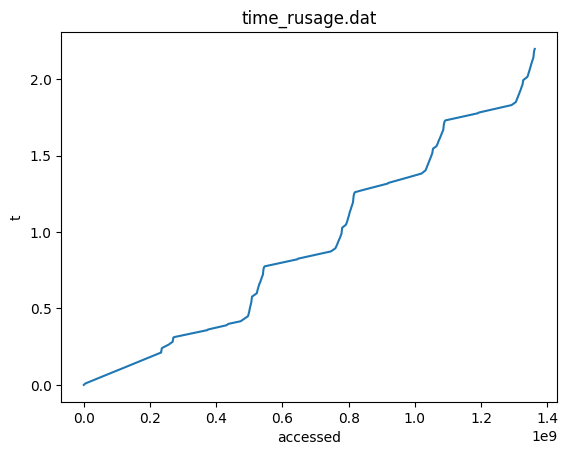

In [66]:
progress_plt("time_rusage.dat", "accessed", "t")

* マイナーフォルト

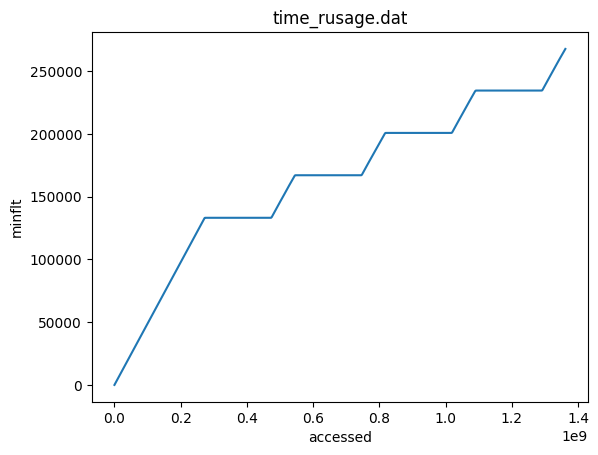

In [67]:
progress_plt("time_rusage.dat", "accessed", "minflt")

* メジャーフォルト

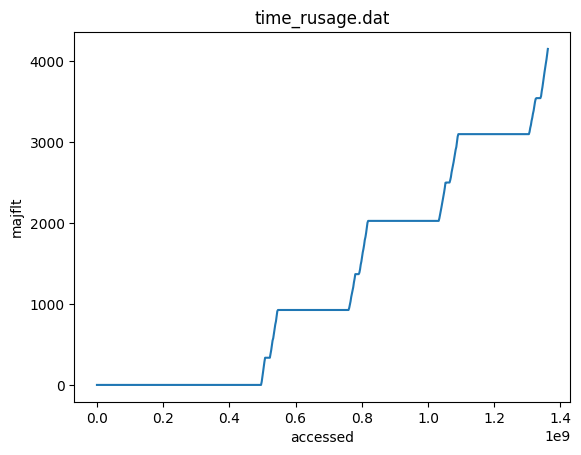

In [68]:
progress_plt("time_rusage.dat", "accessed", "majflt")

.

/tmp/ipykernel_3027185/917081941.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr')


*..............................................*...........*.............*............*...........*.............*.........**............*.....*............*..................................*...........................*........................*............*...*.*..*.*.*.......*.*..*...*..*.*.*........................*.............................*................................*...................*....*..*...*..**.*.....*..*.*.*.*..*.*..*.**.*.*.................*...................*...............*................*................*................*.....*..*..*..*.*..*..**....*...*..*..*.*..*..**.*.*..................*......................*.................*.....................*...................*.......*..*..*..*.*..*.*.*..*.....*.*..*.*.*..*.*.**.*.*done


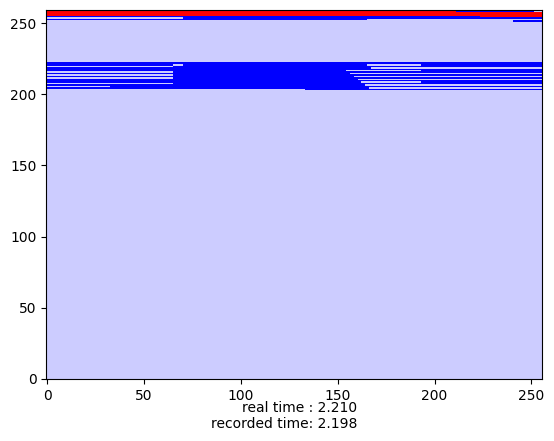

In [70]:
from IPython.display import Video
animate_mincore("mincore.dat", "mincore.mp4", 0.2)
Video("mincore.mp4")